In [26]:
source("/root/workspace/code/midas/preprocess/utils.R")
setwd("/root/workspace/code/midas/")
library(RColorBrewer)
library(patchwork)

parser <- ArgumentParser()
parser$add_argument("--task", type = "character", default = "dogma_full")
parser$add_argument("--method", type = "character", default = "midas_embed")
parser$add_argument("--experiment", type = "character", default = "e0")
parser$add_argument("--model", type = "character", default = "default")
parser$add_argument("--init_model", type = "character", default = "sp_00001899")
parser$add_argument("--load_saved", type = "integer", default = 0)
o <- parser$parse_known_args()[[1]]

data_name <- strsplit(o$task, split = "_")[[1]][1]
config <- parseTOML("configs/data.toml")[[gsub("_vd.*|_vt.*|_transfer$|_ref_.*$", "", o$task)]]
subset_names <- basename(config$raw_data_dirs)
subset_ids <- sapply(seq_along(subset_names) - 1, toString)
input_dirs <- pj("result", o$task, o$experiment, o$model, "predict", o$init_model, paste0("subset_", subset_ids))
pp_dir <- pj("data", "processed", o$task)
output_dir <- pj("result", "comparison", o$task, o$method, o$experiment, o$model, o$init_model)
mkdir(output_dir, remove_old = F)
if (grepl("_vt", o$task)) {
    fn <- paste0("l1_", tail(strsplit(o$task, split = "_")[[1]], 1), ".csv")
    label_paths <- pj(config$raw_data_dirs, "label_seurat", fn)
} else {
    label_paths <- pj(config$raw_data_dirs, "label_seurat", "l1.csv")
}

K <- parseTOML("configs/model.toml")[["default"]]$dim_c
l <- 7.5  # figure size
L <- 10   # figure size
m <- 0.5  # legend margin

## Load preprossed data

In [27]:
z_joint_list <- list()
z_atac_list <- list()
z_rna_list <- list()
z_adt_list <- list()
cell_name_list <- list()
label_list <- list()
is_label <- T
subset_name_list <- list()
S <- length(subset_names)
for (i in seq_along(subset_names)) {
    subset_name <- subset_names[i]

    z_joint_dir <- pj(input_dirs[i], "z", "joint")
    fnames <- dir(path = z_joint_dir, pattern = ".csv$")
    fnames <- str_sort(fnames, decreasing = F)
    N <- length(fnames)
    z_joint_subset_list <- list()
    for (n in seq_along(fnames)) {
        message(paste0("Loading Subset ", i, "/", S, ", File ", n, "/", N))
        z_joint_subset_list[[n]] <- read.csv(file.path(z_joint_dir, fnames[n]), header = F)
    }
    z_joint_list[[subset_name]] <- bind_rows(z_joint_subset_list)

    z_atac_dir <- pj(input_dirs[i], "z", "atac")
    if (dir.exists(z_atac_dir)) {
        z_subset_atac_list <- list()
        for (n in seq_along(fnames)) {
            z_subset_atac_list[[n]] <- read.csv(file.path(z_atac_dir, fnames[n]), header = F)
        }
        z_atac_list[[subset_name]] <- bind_rows(z_subset_atac_list)
    }

    z_rna_dir  <- pj(input_dirs[i], "z", "rna")
    if (dir.exists(z_rna_dir)) {
        z_subset_rna_list <- list()
        for (n in seq_along(fnames)) {
            z_subset_rna_list[[n]] <- read.csv(file.path(z_rna_dir, fnames[n]), header = F)
        }
        z_rna_list[[subset_name]] <- bind_rows(z_subset_rna_list)
    }

    z_adt_dir  <- pj(input_dirs[i], "z", "adt")
    if (dir.exists(z_adt_dir)) {
        z_subset_adt_list <- list()
        for (n in seq_along(fnames)) {
            z_subset_adt_list[[n]] <- read.csv(file.path(z_adt_dir, fnames[n]), header = F)
        }
        z_adt_list[[subset_name]] <- bind_rows(z_subset_adt_list)
    }

    cell_name_list[[subset_name]] <- read.csv(pj(pp_dir, paste0("subset_", subset_ids[i]),
        "cell_names.csv"), header = T)[, 2]
    if (file.exists(label_paths[i])) {
        label_list[[subset_name]] <- read.csv(label_paths[i], header = T)[, 2]
    } else {
        is_label <- F
    }
    subset_name_list[[subset_name]] <- rep(subset_name, length(cell_name_list[[subset_name]]))
}

Loading Subset 1/3, File 1/136

Loading Subset 1/3, File 2/136

Loading Subset 1/3, File 3/136

Loading Subset 1/3, File 4/136

Loading Subset 1/3, File 5/136

Loading Subset 1/3, File 6/136

Loading Subset 1/3, File 7/136

Loading Subset 1/3, File 8/136

Loading Subset 1/3, File 9/136

Loading Subset 1/3, File 10/136

Loading Subset 1/3, File 11/136

Loading Subset 1/3, File 12/136

Loading Subset 1/3, File 13/136

Loading Subset 1/3, File 14/136

Loading Subset 1/3, File 15/136

Loading Subset 1/3, File 16/136

Loading Subset 1/3, File 17/136

Loading Subset 1/3, File 18/136

Loading Subset 1/3, File 19/136

Loading Subset 1/3, File 20/136

Loading Subset 1/3, File 21/136

Loading Subset 1/3, File 22/136

Loading Subset 1/3, File 23/136

Loading Subset 1/3, File 24/136

Loading Subset 1/3, File 25/136

Loading Subset 1/3, File 26/136

Loading Subset 1/3, File 27/136

Loading Subset 1/3, File 28/136

Loading Subset 1/3, File 29/136

Loading Subset 1/3, File 30/136

Loading Subset 1/3,

## Create seurat objects

In [28]:
objs <- list()
if (length(z_atac_list) > 0) {
    counts <- t(data.matrix(bind_rows(z_atac_list))) * 0  # pseudo counts
    colnames(counts) <- do.call("c", unname(cell_name_list[names(z_atac_list)]))
    rownames(counts) <- paste0("feat-", seq_len(nrow(counts)))
    obj_atac <- CreateSeuratObject(counts = counts, assay = "joint")

    z <- data.matrix(bind_rows(z_atac_list))
    c <- z[, 1:K]
    colnames(c) <- paste0("c_", seq_len(ncol(c)))
    rownames(c) <- colnames(obj_atac)
    obj_atac[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "joint")

    u <- z[, (K+1):(K+2)]
    colnames(u) <- paste0("u_", seq_len(ncol(u)))
    rownames(u) <- colnames(obj_atac)
    obj_atac[["u"]] <- CreateDimReducObject(embeddings = u, key = "u_", assay = "joint")

    obj_atac@meta.data$batch <- factor(x = do.call("c", unname(subset_name_list[names(z_atac_list)])), levels = subset_names)
    table(obj_atac@meta.data$batch)[unique(obj_atac@meta.data$batch)]
    if (is_label) {
        obj_atac@meta.data$l1 <- do.call("c", unname(label_list[names(z_atac_list)]))
    } else {
        obj_atac@meta.data$l1 <- obj_atac@meta.data$batch
    }
    obj_atac@meta.data$mod <- "atac"
    obj_atac <- RenameCells(obj_atac, add.cell.id = "atac")

    obj_atac
    objs[["atac"]] <- obj_atac
}

In [29]:
if (length(z_rna_list) > 0) {
    counts <- t(data.matrix(bind_rows(z_rna_list))) * 0  # pseudo counts
    colnames(counts) <- do.call("c", unname(cell_name_list[names(z_rna_list)]))
    rownames(counts) <- paste0("feat-", seq_len(nrow(counts)))
    obj_rna <- CreateSeuratObject(counts = counts, assay = "joint")

    z <- data.matrix(bind_rows(z_rna_list))
    c <- z[, 1:K]
    colnames(c) <- paste0("c_", seq_len(ncol(c)))
    rownames(c) <- colnames(obj_rna)
    obj_rna[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "joint")

    u <- z[, (K+1):(K+2)]
    colnames(u) <- paste0("u_", seq_len(ncol(u)))
    rownames(u) <- colnames(obj_rna)
    obj_rna[["u"]] <- CreateDimReducObject(embeddings = u, key = "u_", assay = "joint")

    obj_rna@meta.data$batch <- factor(x = do.call("c", unname(subset_name_list[names(z_rna_list)])), levels = subset_names)
    table(obj_rna@meta.data$batch)[unique(obj_rna@meta.data$batch)]
    if (is_label) {
        obj_rna@meta.data$l1 <- do.call("c", unname(label_list[names(z_rna_list)]))
    } else {
        obj_rna@meta.data$l1 <- obj_rna@meta.data$batch
    }
    obj_rna@meta.data$mod <- "rna"
    obj_rna <- RenameCells(obj_rna, add.cell.id = "rna")

    obj_rna
    objs[["rna"]] <- obj_rna
}

In [30]:
if (length(z_adt_list) > 0) {
    counts <- t(data.matrix(bind_rows(z_adt_list))) * 0  # pseudo counts
    colnames(counts) <- do.call("c", unname(cell_name_list[names(z_adt_list)]))
    rownames(counts) <- paste0("feat-", seq_len(nrow(counts)))
    obj_adt <- CreateSeuratObject(counts = counts, assay = "joint")

    z <- data.matrix(bind_rows(z_adt_list))
    c <- z[, 1:K]
    colnames(c) <- paste0("c_", seq_len(ncol(c)))
    rownames(c) <- colnames(obj_adt)
    obj_adt[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "joint")

    u <- z[, (K+1):(K+2)]
    colnames(u) <- paste0("u_", seq_len(ncol(u)))
    rownames(u) <- colnames(obj_adt)
    obj_adt[["u"]] <- CreateDimReducObject(embeddings = u, key = "u_", assay = "joint")

    obj_adt@meta.data$batch <- factor(x = do.call("c", unname(subset_name_list[names(z_adt_list)])), levels = subset_names)
    table(obj_adt@meta.data$batch)[unique(obj_adt@meta.data$batch)]
    if (is_label) {
        obj_adt@meta.data$l1 <- do.call("c", unname(label_list[names(z_adt_list)]))
    } else {
        obj_adt@meta.data$l1 <- obj_adt@meta.data$batch
    }
    obj_adt@meta.data$mod <- "adt"
    obj_adt <- RenameCells(obj_adt, add.cell.id = "adt")

    obj_adt
    objs[["adt"]] <- obj_adt
}

In [31]:
counts <- t(data.matrix(bind_rows(z_joint_list))) * 0  # pseudo counts
colnames(counts) <- do.call("c", unname(cell_name_list))
rownames(counts) <- paste0("feat-", seq_len(nrow(counts)))
obj_joint <- CreateSeuratObject(counts = counts, assay = "joint")

z <- data.matrix(bind_rows(z_joint_list))
c <- z[, 1:K]
colnames(c) <- paste0("c_", seq_len(ncol(c)))
rownames(c) <- colnames(obj_joint)
obj_joint[["c"]] <- CreateDimReducObject(embeddings = c, key = "c_", assay = "joint")

u <- z[, (K+1):(K+2)]
colnames(u) <- paste0("u_", seq_len(ncol(u)))
rownames(u) <- colnames(obj_joint)
obj_joint[["u"]] <- CreateDimReducObject(embeddings = u, key = "u_", assay = "joint")

obj_joint@meta.data$batch <- factor(x = do.call("c", unname(subset_name_list)), levels = subset_names)
table(obj_joint@meta.data$batch)[unique(obj_joint@meta.data$batch)]
if (is_label) {
    obj_joint@meta.data$l1 <- do.call("c", unname(label_list))
} else {
    obj_joint@meta.data$l1 <- obj_joint@meta.data$batch
}
obj_joint@meta.data$mod <- "joint"
obj_joint <- RenameCells(obj_joint, add.cell.id = "joint")

obj_joint
objs[["joint"]] <- obj_joint


  ica    BM    bm 
34592 10671 26286 

An object of class Seurat 
34 features across 71549 samples within 1 assay 
Active assay: joint (34 features, 0 variable features)
 2 dimensional reductions calculated: c, u

In [32]:
if (o$load_saved == 1) {
    obj_merged <- LoadH5Seurat(pj(output_dir, "obj_vis.h5seurat"), reductions = c("cUMAP", "uUMAP"))
} else {
    obj_merged <- merge(objs[[1]], y = unlist(objs[-1]), merge.dr = c("c", "u"))
    obj_merged@meta.data$mod <- factor(x = obj_merged@meta.data$mod, levels = names(objs))
    obj_merged
    obj_merged <- RunUMAP(obj_merged, reduction = "c", dims = 1:K, reduction.name = "cUMAP")
    obj_merged <- RunUMAP(obj_merged, reduction = "u", dims = 1:2, metric = "euclidean", reduction.name = "uUMAP")
    SaveH5Seurat(obj_merged, pj(output_dir, "obj_vis.h5seurat"), overwrite = T)
}

obj_mod <- SplitObject(obj_merged, split.by = "mod")
obj <- lapply(obj_mod, SplitObject, split.by = "batch")

13:25:24 UMAP embedding parameters a = 0.9922 b = 1.112

13:25:24 Read 180055 rows and found 32 numeric columns

13:25:24 Using Annoy for neighbor search, n_neighbors = 30

13:25:24 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

13:25:48 Writing NN index file to temp file /tmp/Rtmp05sQmE/file349f85c288add

13:25:48 Searching Annoy index using 64 threads, search_k = 3000

13:25:50 Annoy recall = 100%

13:25:52 Commencing smooth kNN distance calibration using 64 threads
 with target n_neighbors = 30

13:25:58 Initializing from normalized Laplacian + noise (using irlba)

13:26:16 Commencing optimization for 200 epochs, with 7643756 positive edges

13:27:48 Optimization finished

13:27:48 UMAP embedding parameters a = 0.9922 b = 1.112

13:27:48 Read 180055 rows and found 

## Visualization

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`



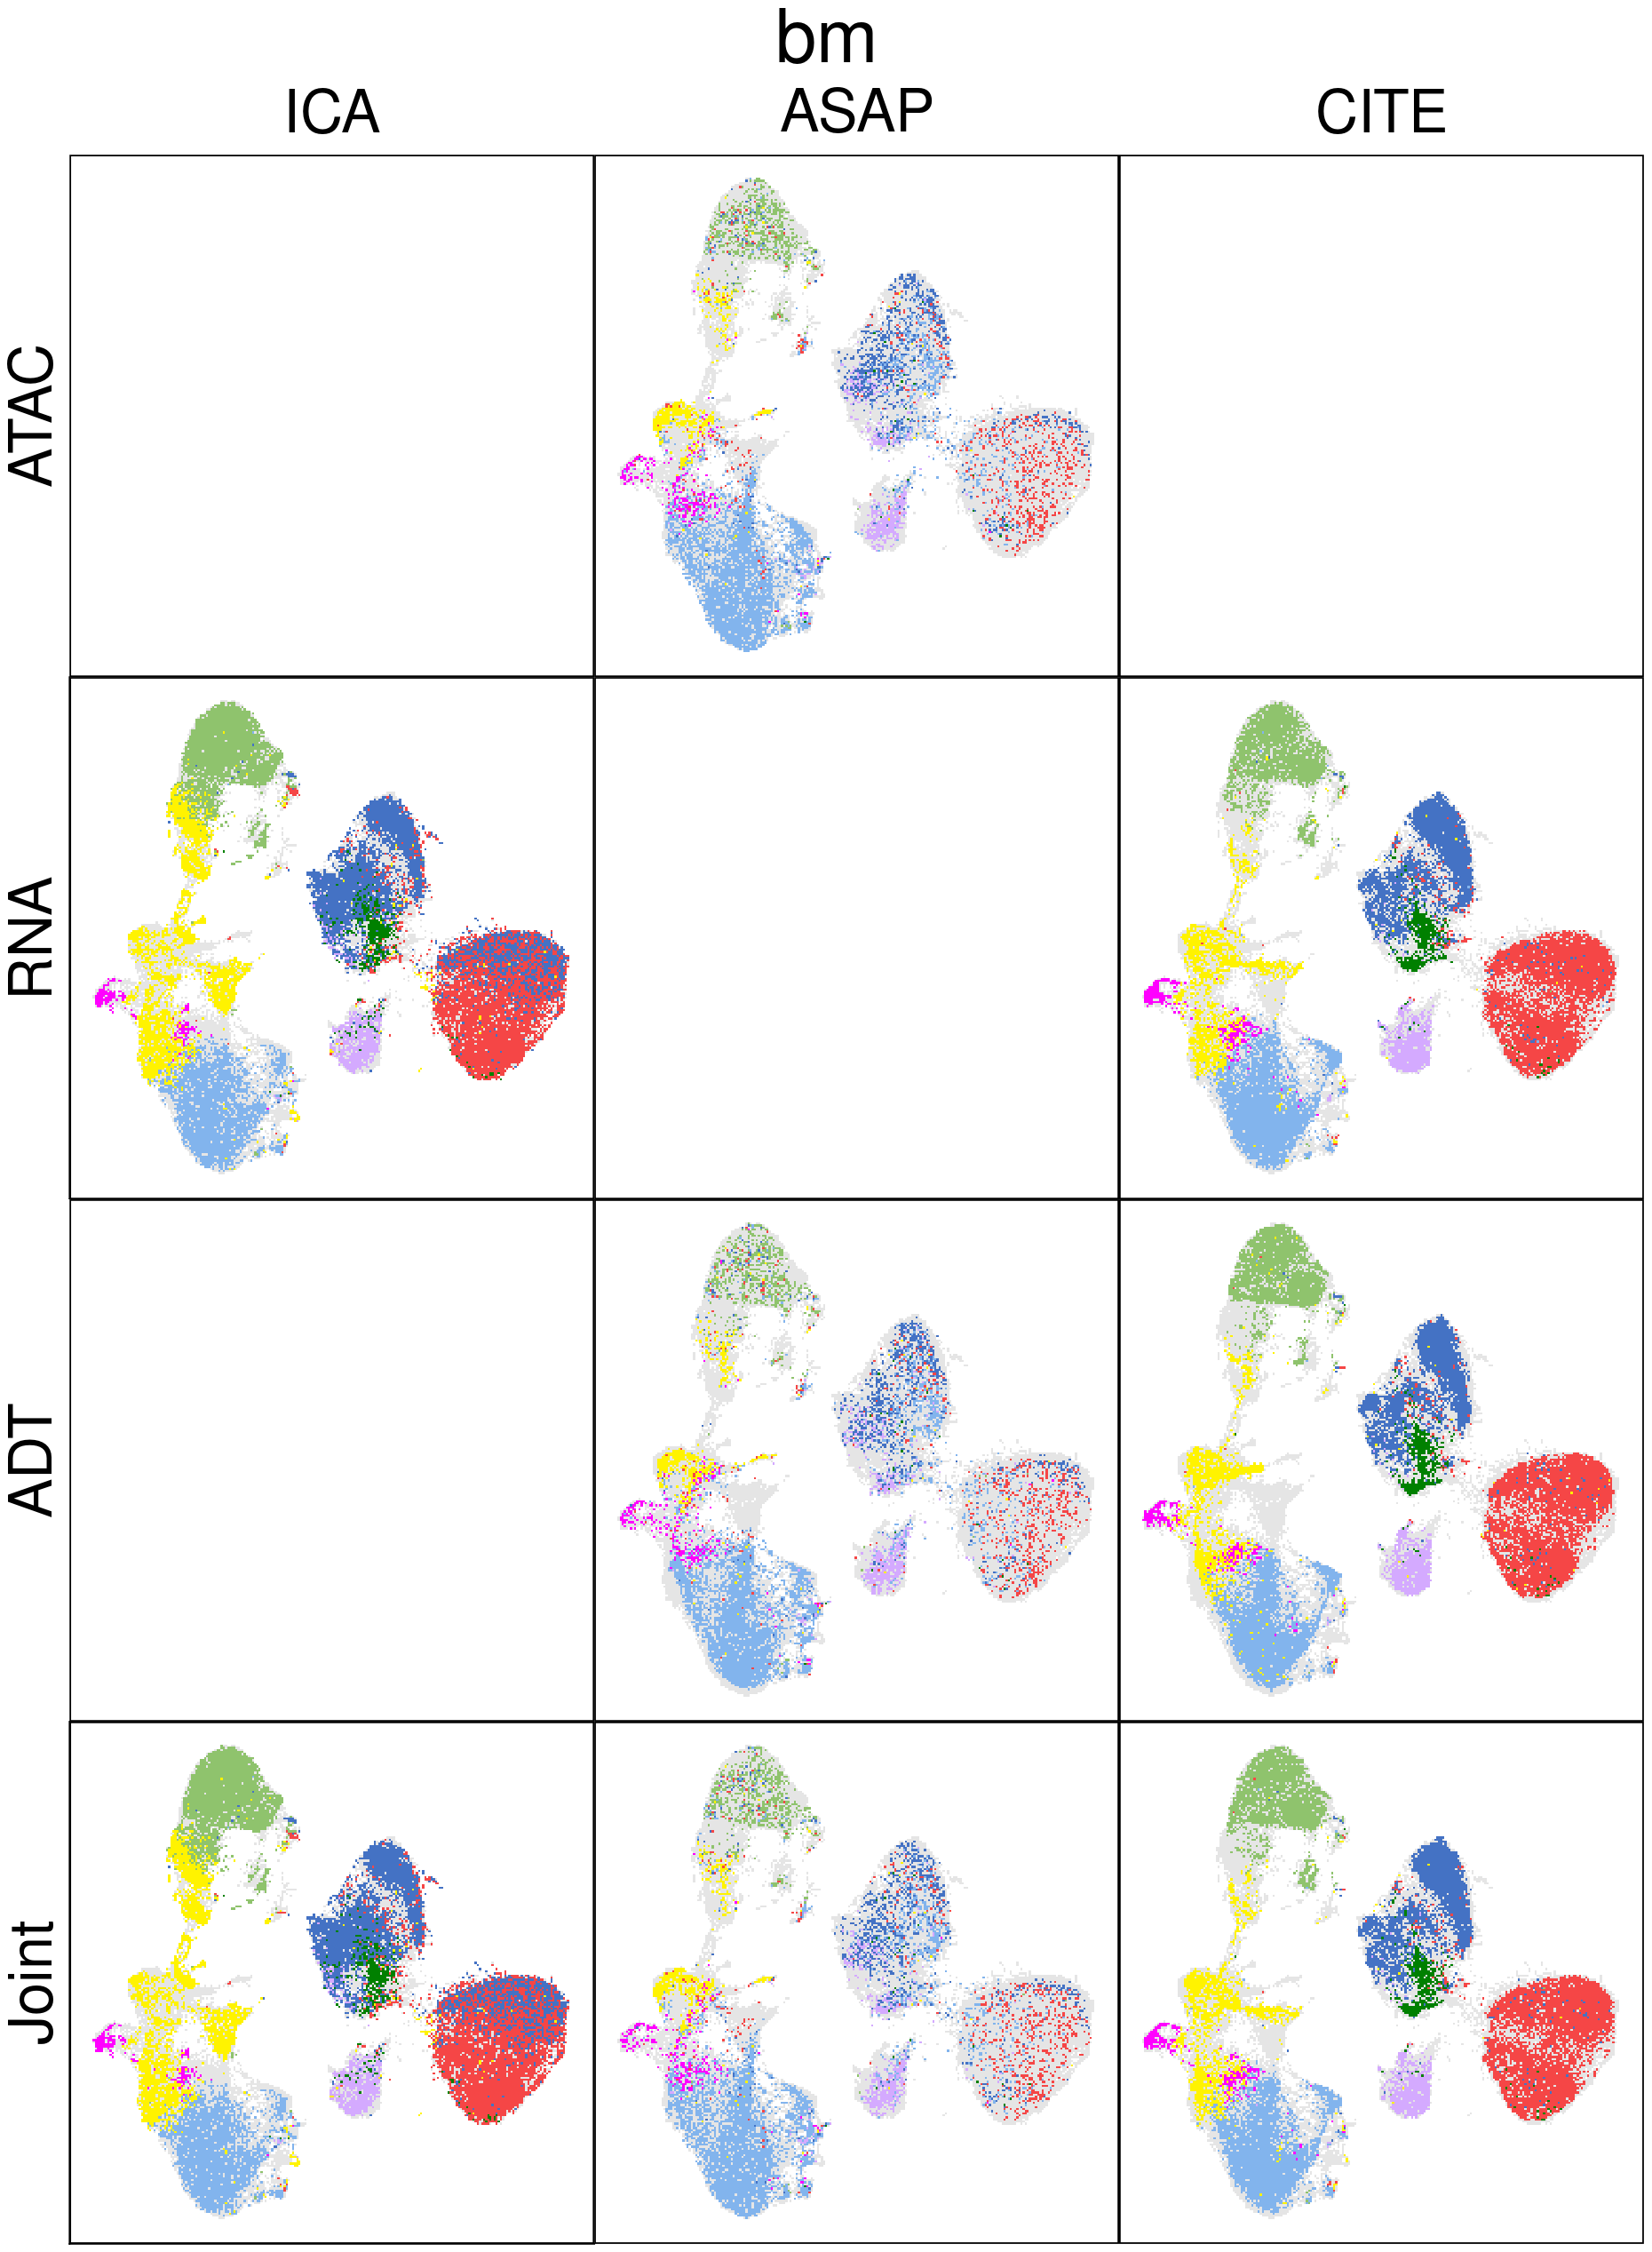

In [33]:
pal <- col_8
labels <- str_sort(unique(obj_merged@meta.data$l1))
label_to_color <- list()
for (i in seq_along(labels)) {
    label_to_color[[labels[i]]] <- pal[i]
}
order <- c(str_sort(unique(obj_merged@meta.data$l1), decreasing = T), "Unselected")
plt <- NULL
for (m in names(objs)) {
    subsets <- names(obj[[m]])
    for (s in subset_names) {
        if (s %in% subsets) {
            # set groups for highlighting
            obj_merged@meta.data$highlight <- "Unselected"
            select_mask <- colnames(obj_merged) %in% colnames(obj[[m]][[s]])
            obj_merged@meta.data$highlight[select_mask] <- obj_merged@meta.data$l1[select_mask]
            # set label-specific colors
            cols <- c("#E5E5E5")
            for (label in str_sort(unique(obj[[m]][[s]]@meta.data$l1))) {
                cols <- c(cols, label_to_color[[label]])
            }
            # plot
            p <- DimPlot(obj_merged, reduction = "cUMAP", group.by = "highlight", repel = T,
                #  label.size = 4, pt.size = 0.1, shuffle = F, cols = cols, order = order, raster = F)
                 label.size = 4, pt.size = 0.1, shuffle = F, cols = cols, order = order, raster = T, raster.dpi = c(250, 250))
        } else {
            # p <- plot_spacer()
            p <- ggplot()# + theme_void()
        }

        if (m == names(objs)[1]) {
            s_ <- gsub("ica", "ICA", gsub("^BM$", "ASAP", gsub("^bm$", "CITE", 
                  gsub("^w", "W", gsub("lll", "LLL", gsub("dig", "DIG", gsub("ctrl", "Ctrl", gsub("stim", "Stim", s))))))))
            p <- p + ggtitle(s_) + theme(plot.title = element_text(face = "plain", hjust = 0.5, size = 40))
        } else {
            p <- p + theme(plot.title = element_blank())
        }

        if (data_name == "dogma" & s == "lll_ctrl" |
            data_name == "teadog" & s == "w1" |
            data_name == "bm" & s == "ica") {
            p <- p + theme(axis.title.y = element_text(size = 40),
                           axis.title.x = element_blank(),
                           axis.text.x = element_blank(),
                           axis.text.y = element_blank(),
                           axis.ticks.x = element_blank(),
                           axis.ticks.y = element_blank()) + labs(y = gsub("JOINT", "Joint", toupper(m)))
        } else {
            p <- p + NoAxes()
        }

        p <- p + NoLegend() +
            theme(panel.border = element_rect(color = "black", linewidth = 1),
            axis.ticks.length = unit(0, "pt"), plot.margin = margin(0, 0, 0, 0)) +
            labs(colour = "Cell type")

        if (!is_label) {
            p <- p + NoLegend()
        }

        if (is.null(plt)) {
            plt <- p
        } else {
            plt <- plt + p
        }
    }
}
# plt <- plt + plot_layout(nrow = length(objs), guides = "collect") +
#        plot_annotation(title = rename_task(o$task),
#                        theme = theme(plot.title = element_text(size = 50, hjust = 0.5))
#                       ) & theme(legend.position = "right")
plt <- plt + plot_layout(nrow = length(objs)) +
       plot_annotation(title = rename_task(o$task),
                       theme = theme(plot.title = element_text(size = 50, hjust = 0.5))
                      )

w <- 5 * S + 0.5
h <- 5 * length(objs) + 0.5 + 0.625
plt_size(w, h)
plt
save_path <- pj(output_dir, paste(o$task, o$method, o$experiment, o$model, o$init_model, "c_all", sep = "_"))
ggsave(plot = plt, file = paste0(save_path, ".png"), width = w, height = h, limitsize = F)
ggsave(plot = plt, file = paste0(save_path, ".pdf"), width = w, height = h, limitsize = F)

Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Rasterizing points since number of points exceeds 100,000.
To disable this behavior set `raster=FALSE`

Scale for colour is already present.
Adding 

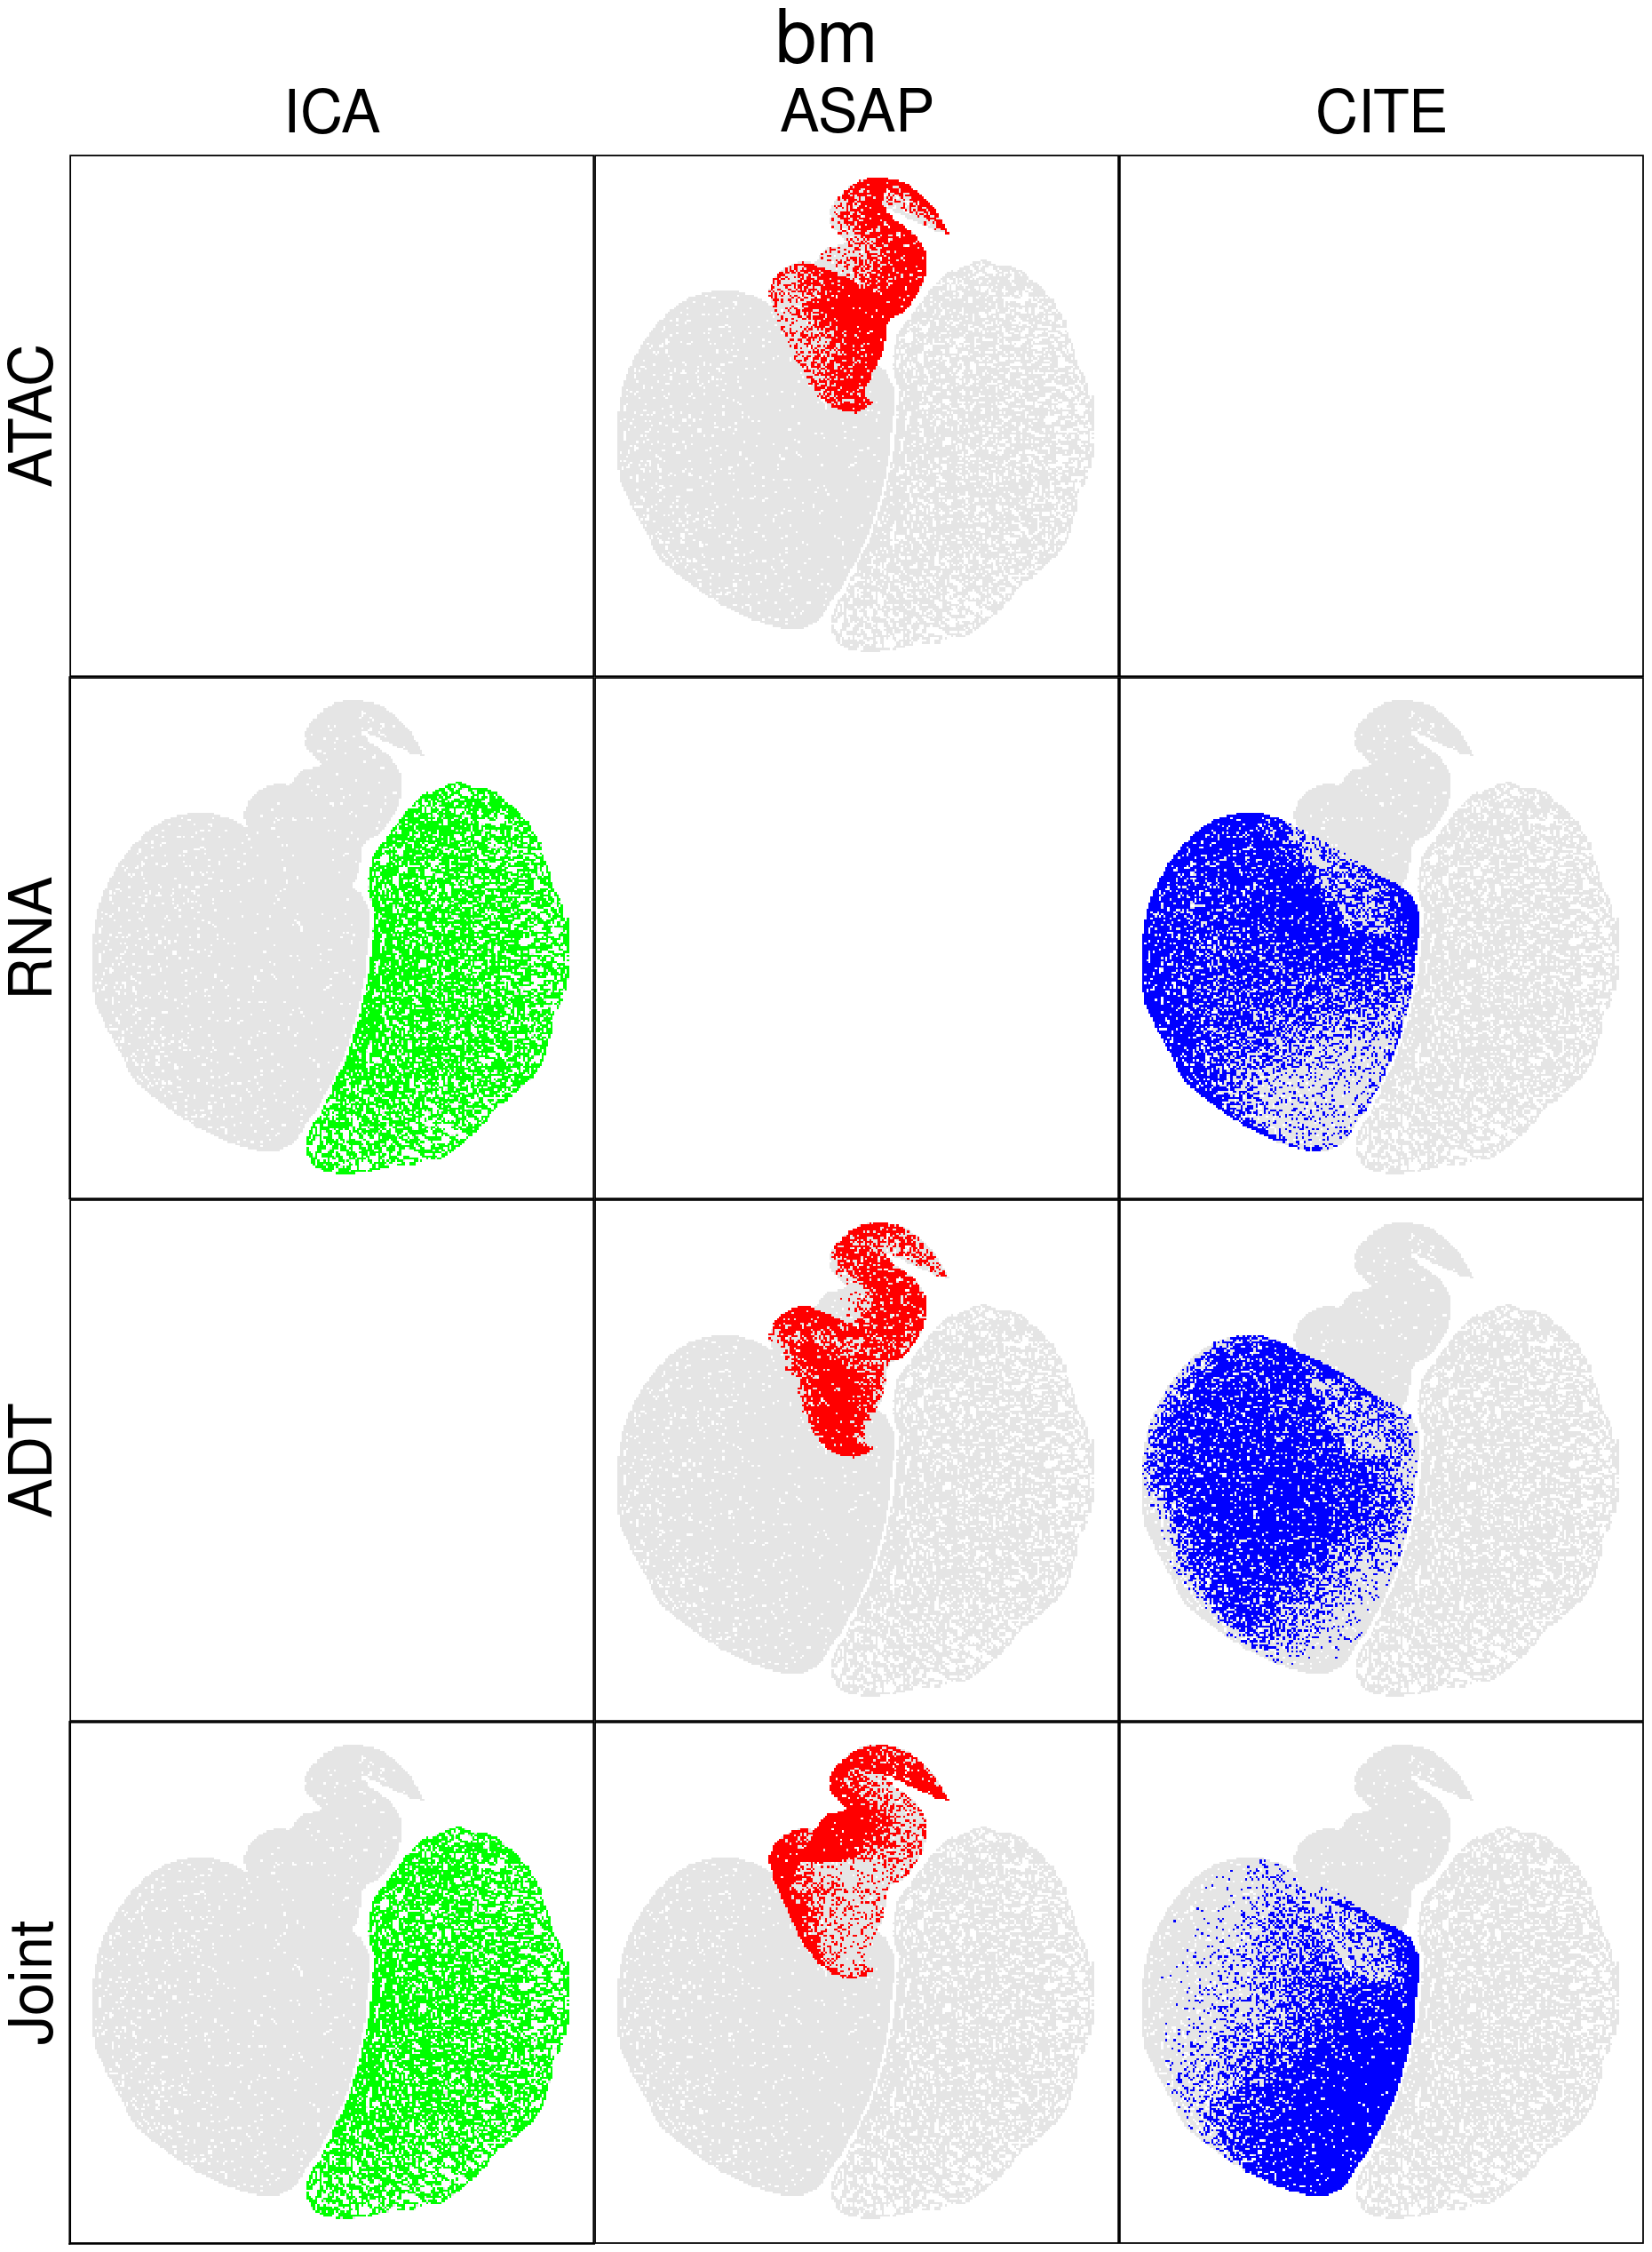

In [34]:
pal <- col_4
cols <- c("#E5E5E5", pal)
order <- c(rev(subset_names), "Unselected")
plt <- NULL
for (m in names(objs)) {
    subsets <- names(obj[[m]])
    for (s in subset_names) {
        if (s %in% subsets) {
            # set groups for highlighting
            obj_merged@meta.data$highlight <- "Unselected"
            select_mask <- colnames(obj_merged) %in% colnames(obj[[m]][[s]])
            obj_merged@meta.data$highlight[select_mask] <- obj_merged@meta.data$batch[select_mask]
            # plot
            p <- DimPlot(obj_merged, reduction = "uUMAP", group.by = "highlight", repel = T,
                 label.size = 4, pt.size = 0.1, shuffle = F, cols = cols, order = order, raster = T, raster.dpi = c(250, 250))
        } else {
            # p <- plot_spacer()
            p <- ggplot()# + theme_void()
        }

        if (m == names(objs)[1]) {
            s_ <- gsub("ica", "ICA", gsub("^BM$", "ASAP", gsub("^bm$", "CITE", 
                  gsub("^w", "W", gsub("lll", "LLL", gsub("dig", "DIG", gsub("ctrl", "Ctrl", gsub("stim", "Stim", s))))))))
            p <- p + ggtitle(s_) + theme(plot.title = element_text(face = "plain", hjust = 0.5, size = 40))
        } else {
            p <- p + theme(plot.title = element_blank())
        }

        if (data_name == "dogma" & s == "lll_ctrl" |
            data_name == "teadog" & s == "w1" |
            data_name == "bm" & s == "ica") {
            p <- p + theme(axis.title.y = element_text(size = 40),
                           axis.title.x = element_blank(),
                           axis.text.x = element_blank(),
                           axis.text.y = element_blank(),
                           axis.ticks.x = element_blank(),
                           axis.ticks.y = element_blank()) + labs(y = gsub("JOINT", "Joint", toupper(m)))
        } else {
            p <- p + NoAxes()
        }

        p <- p  + NoLegend() + 
            theme(panel.border = element_rect(color = "black", linewidth = 1),
            axis.ticks.length = unit(0, "pt"), plot.margin = margin(0, 0, 0, 0)) +
            scale_colour_manual(values = cols, drop = FALSE) +
            labs(colour = "Sample")

        if (!is_label) {
            p <- p + NoLegend()
        }

        if (is.null(plt)) {
            plt <- p
        } else {
            plt <- plt + p
        }
    }
}
# plt <- plt + plot_layout(nrow = length(objs), guides = "collect") +
#        plot_annotation(title = rename_task(o$task),
#                        theme = theme(plot.title = element_text(size = 50, hjust = 0.5))
#                       ) & theme(legend.position = "right")
plt <- plt + plot_layout(nrow = length(objs)) +
       plot_annotation(title = rename_task(o$task),
                       theme = theme(plot.title = element_text(size = 50, hjust = 0.5))
                      )

w <- 5 * S + 0.5
h <- 5 * length(objs) + 0.5 + 0.625
plt_size(w, h)
plt
save_path <- pj(output_dir, paste(o$task, o$method, o$experiment, o$model, o$init_model, "u_all", sep = "_"))
ggsave(plot = plt, file = paste0(save_path, ".png"), width = w, height = h, limitsize = F)
ggsave(plot = plt, file = paste0(save_path, ".pdf"), width = w, height = h, limitsize = F)
